## Weaviate 1.31 Enablement session

### Key features

- Shard movement between nodes
- MUVERA encoding algorithm for multi-vector embeddings
- Vectorizer changes
- HNSW snapshotting

### Connect to Weaviate

In [1]:
import dotenv

dotenv.load_dotenv(verbose=True)

True

In [2]:
import weaviate
import os

client = weaviate.connect_to_local(
    headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),
        "X-JinaAI-Api-Key": os.getenv("JINAAI_API_KEY")
    }
)

In [3]:
client.get_meta()["version"]

'1.31.0-rc.0'

Check the cluster setup:

In [4]:
client.cluster.nodes()

[Node(git_hash='a6ede0c', name='node1', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='a6ede0c', name='node2', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='a6ede0c', name='node3', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0')]

Pre-load some data:

In [5]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
    ],
    replication_config=Configure.replication(factor=2),  # Note - this just a demo - do NOT use a RF of 2 in production - use 3 or above odd number
    sharding_config=Configure.sharding(
        desired_count=5  # To demonstrate sharding, we set it to an arbitrary high number (for our dataset size, anyway)
    )
)

c = client.collections.get(collection_name)

objects = [
    {"title": "Howl's Moving Castle", "body": "A fantasy novel by Diana Wynne Jones."},
    {"title": "The Hobbit", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "The Hitchhiker's Guide to the Galaxy", "body": "A science fiction novel by Douglas Adams."},
    {"title": "The Great Gatsby", "body": "A novel by F. Scott Fitzgerald."},
    {"title": "1984", "body": "A dystopian novel by George Orwell."},
    {"title": "To Kill a Mockingbird", "body": "A novel by Harper Lee."},
    {"title": "Pride and Prejudice", "body": "A novel by Jane Austen."},
    {"title": "The Catcher in the Rye", "body": "A novel by J.D. Salinger."},
    {"title": "The Lord of the Rings", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "Brave New World", "body": "A dystopian novel by Aldous Huxley."},
    {"title": "Fahrenheit 451", "body": "A dystopian novel by Ray Bradbury."},
    {"title": "The Picture of Dorian Gray", "body": "A novel by Oscar Wilde."},
]

c.data.insert_many(objects)

import time

start_time = time.time()
print("Waiting for object count to update...")

while True:
    n = client.cluster.nodes(collection=collection_name, output="verbose")[0]
    s = n.shards[0]
    if s.object_count != 0:
        print(f"On node {n.name} and shard {s.name} - obj count: {s.object_count}")
        break
    time.sleep(10)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.1f}s")

finish_time = time.time()
print(f"Time taken for obj count to update: {finish_time - start_time} seconds")

/workspaces/weaviate_enablement_1_31/.venv/lib/python3.11/site-packages/weaviate/collections/classes/config.py:1977: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


Waiting for object count to update...
Elapsed time: 10.0s
Elapsed time: 20.0s
Elapsed time: 30.0s
Elapsed time: 40.0s
Elapsed time: 50.0s
Elapsed time: 60.0s
Elapsed time: 70.0s
On node node1 and shard AgCEHJ5sRZP5 - obj count: 1
Time taken for obj count to update: 70.04944038391113 seconds


In [6]:
len(c)

12

## Move shards

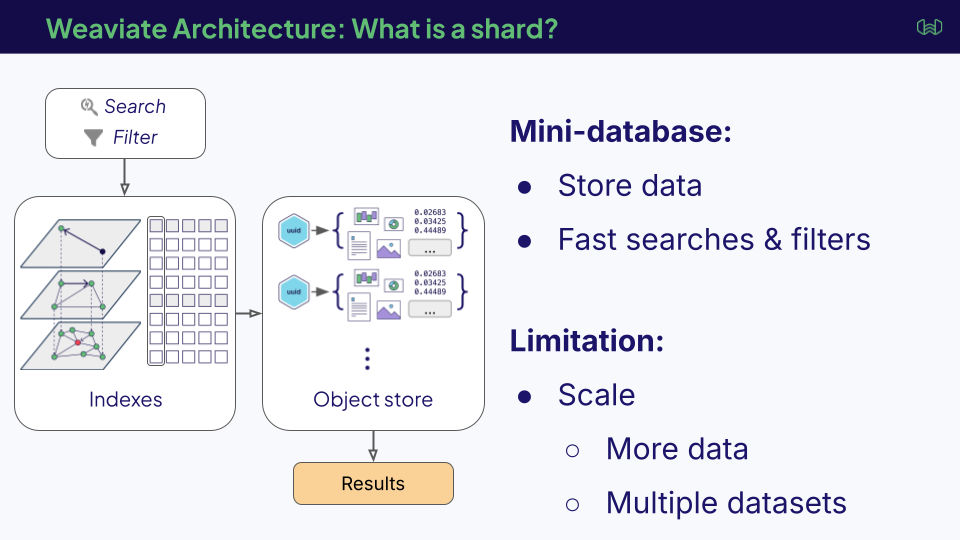

In [7]:
from IPython.display import Image, display

img_w = 600
display(Image('./assets/shards-1.png', width=img_w))

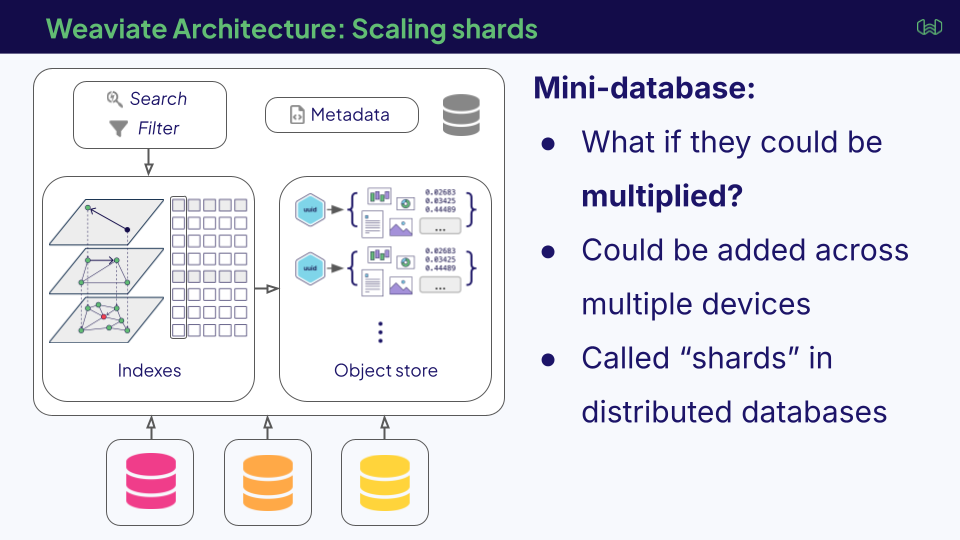

In [8]:
display(Image('./assets/shards-2.png', width=img_w))

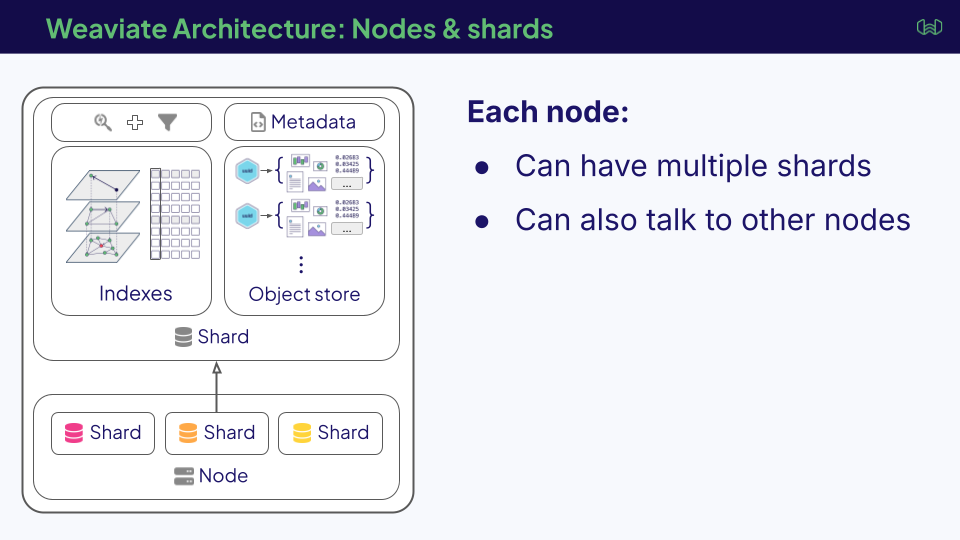

In [9]:
display(Image('./assets/shards-3.png', width=img_w))

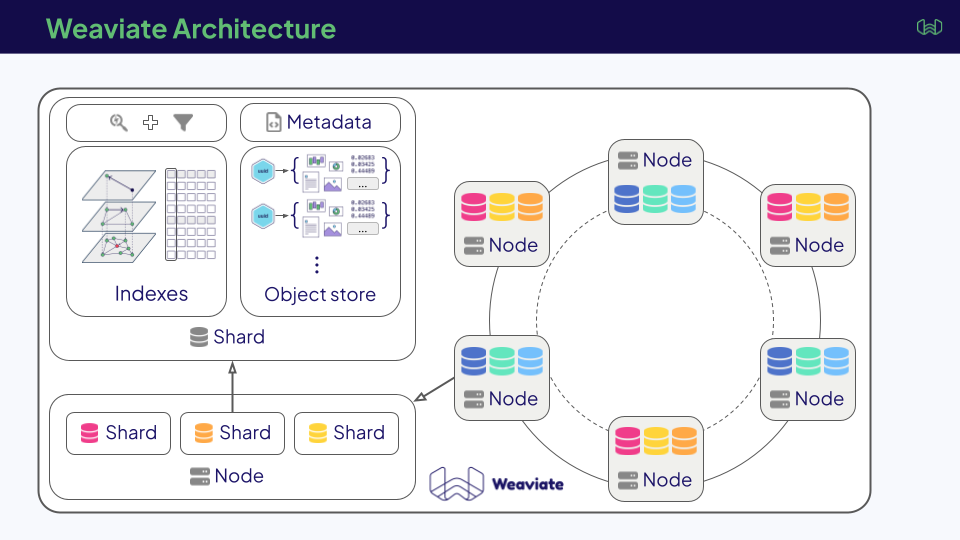

In [10]:
display(Image('./assets/shards-4.png', width=img_w))

In [11]:
nodes_response = client.cluster.nodes(collection=collection_name, output="verbose")

for n in nodes_response:
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")


Node node1 has 3 shards
Shard AgCEHJ5sRZP5 has 1 objects from TempCollection
Shard WSHMMnnGozzy has 1 objects from TempCollection
Shard ey5TM8S9blLh has 5 objects from TempCollection

Node node2 has 4 shards
Shard AgCEHJ5sRZP5 has 1 objects from TempCollection
Shard NbnH8PHsPaya has 3 objects from TempCollection
Shard ey5TM8S9blLh has 5 objects from TempCollection
Shard iWgciV070Ooy has 2 objects from TempCollection

Node node3 has 3 shards
Shard NbnH8PHsPaya has 3 objects from TempCollection
Shard iWgciV070Ooy has 2 objects from TempCollection
Shard WSHMMnnGozzy has 1 objects from TempCollection


In [12]:
n = nodes_response[0]
candidate_shard = None
for src_shard in n.shards:
    node2_shards = [
        n2_shard.name for n2_shard in nodes_response[1].shards
    ]
    if src_shard.name not in node2_shards:
        candidate_shard = src_shard
        break

print(f"Candidate shard to move: {candidate_shard.name}")

SHARD_ID = candidate_shard.name

Candidate shard to move: WSHMMnnGozzy


In [13]:
import requests
import json

# Shard move parameters
SOURCE_NODE = "node1"
DESTINATION_NODE = "node2"

# Create the request payload
payload = {
    "sourceNodeName": "node1",
    "destinationNodeName": DESTINATION_NODE,
    "collectionId": collection_name,
    "shardId": SHARD_ID,
    "transferType": "MOVE"  # Use "MOVE" to relocate the shard, or "COPY" to replicate it
}

# Set up the headers
headers = {
    "Content-Type": "application/json"
}

# Make the API request
response = requests.post(
    f"http://localhost:8080/v1/replication/replicate",
    headers=headers,
    data=json.dumps(payload)
)

operation_id = response.json().get("id")

# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

{'collection': 'TempCollection', 'id': 'b9719cf2-955b-4a7d-ace9-a0765adedf3b', 'shardId': 'WSHMMnnGozzy', 'sourceNodeId': 'node1', 'status': {'errors': None, 'state': 'REGISTERED'}, 'statusHistory': None, 'targetNodeId': 'node2', 'transferType': 'MOVE'}
Shard move operation status:
Status: REGISTERED


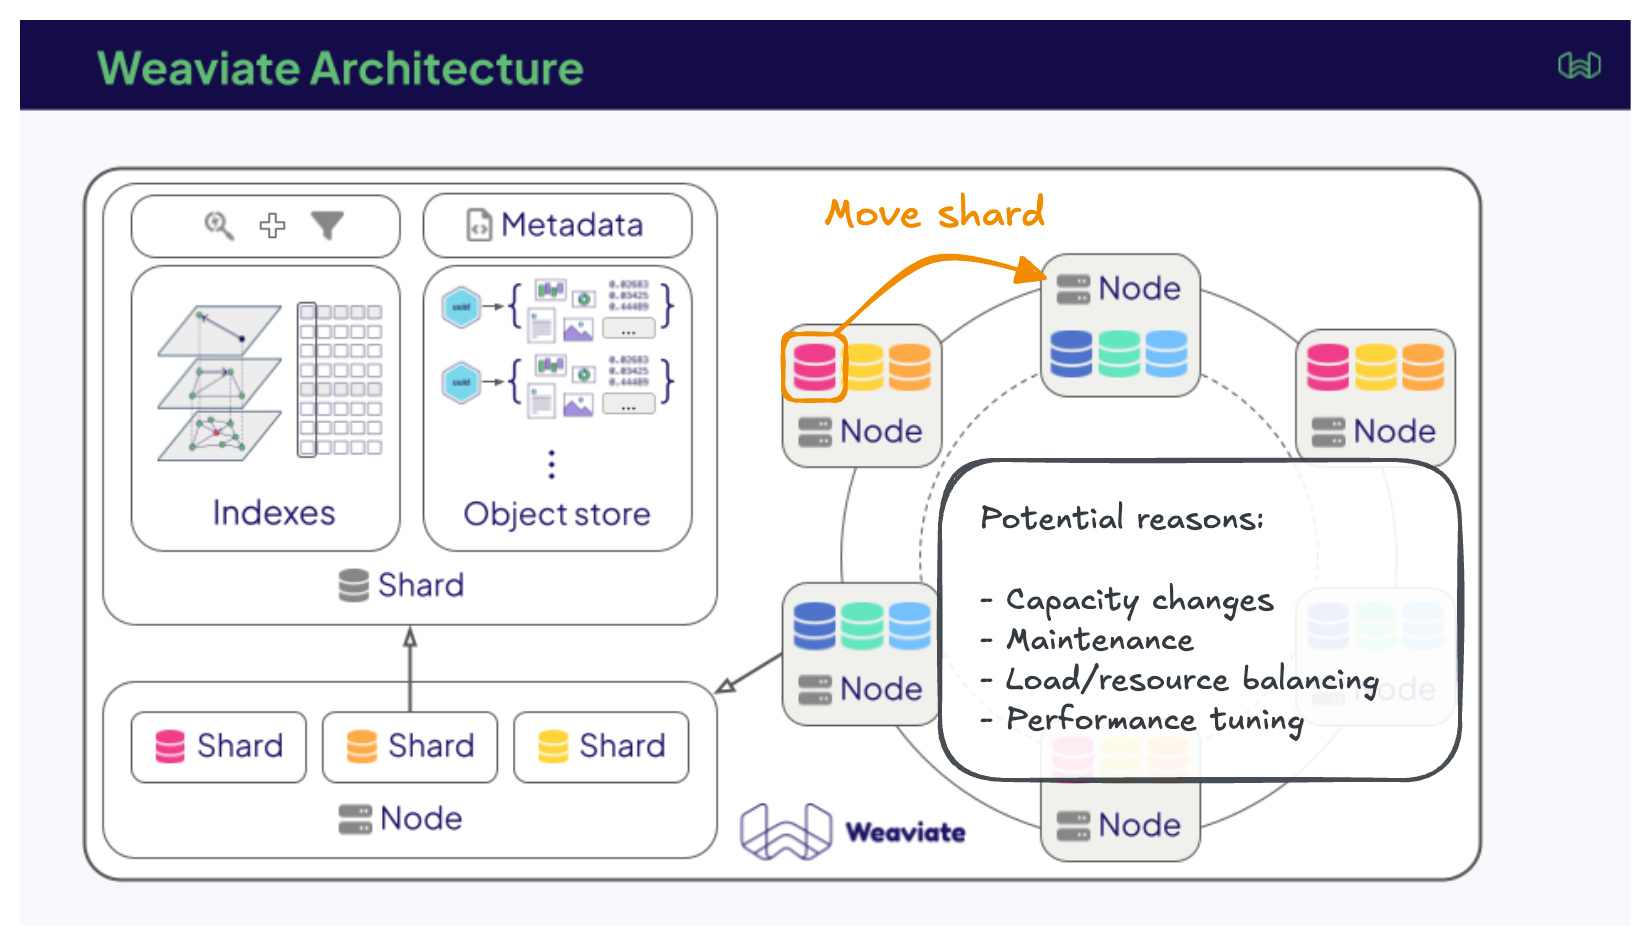

In [14]:
display(Image('./assets/shards-5.png', width=img_w))

Check the status to see if it's finished:

In [19]:
# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

{'collection': 'TempCollection', 'id': 'b9719cf2-955b-4a7d-ace9-a0765adedf3b', 'shardId': 'WSHMMnnGozzy', 'sourceNodeId': 'node1', 'status': {'errors': None, 'state': 'REGISTERED'}, 'statusHistory': None, 'targetNodeId': 'node2', 'transferType': 'MOVE'}
Shard move operation status:
Status: REGISTERED


In [20]:
for n in client.cluster.nodes(collection=collection_name, output="verbose"):
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")


Node node1 has 3 shards
Shard AgCEHJ5sRZP5 has 1 objects from TempCollection
Shard WSHMMnnGozzy has 1 objects from TempCollection
Shard ey5TM8S9blLh has 5 objects from TempCollection

Node node2 has 4 shards
Shard AgCEHJ5sRZP5 has 1 objects from TempCollection
Shard NbnH8PHsPaya has 3 objects from TempCollection
Shard ey5TM8S9blLh has 5 objects from TempCollection
Shard iWgciV070Ooy has 2 objects from TempCollection

Node node3 has 3 shards
Shard NbnH8PHsPaya has 3 objects from TempCollection
Shard iWgciV070Ooy has 2 objects from TempCollection
Shard WSHMMnnGozzy has 1 objects from TempCollection


## MUVERA

Note - check that this is the branch being used:

`uv pip install git+https://github.com/weaviate/weaviate-python-client.git@dev/1.31`

In [ ]:
from IPython.display import Image, display

img_w = 800
display(Image('./assets/mv_explained1.png', width=img_w))

In [ ]:
from IPython.display import Image, display

img_w = 800
display(Image('./assets/mv_explained2.png', width=img_w))

In [ ]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2colbert_jinaai(
            name="custom_mv",
            source_properties=["title", "body"],
            vector_index_config=Configure.VectorIndex.hnsw(
                multi_vector=Configure.VectorIndex.MultiVector.multi_vector(
                    encoding=Configure.VectorIndex.MultiVector.Encoding.muvera()
                )
            )
        ),
    ],
    replication_config=Configure.replication(factor=3)
)

In [ ]:
objects = [
    {"title": "Howl's Moving Castle", "body": "A fantasy novel by Diana Wynne Jones."},
    {"title": "The Hobbit", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "The Hitchhiker's Guide to the Galaxy", "body": "A science fiction novel by Douglas Adams."},
]

In [ ]:
c = client.collections.get(collection_name)

with c.batch.fixed_size(200) as batch:
    for i, obj in enumerate(objects):
        batch.add_object(
            properties=obj,
        )

In [ ]:
r = c.query.near_text(
    query="a bunch of friends travelling around unseen places"
)

for o in r.objects:
    print(o.properties)

## Vectorizer changes

Note - check that this is the branch being used:

`uv pip install git+https://github.com/weaviate/weaviate-python-client.git@1.31/support-adding-vectors`

In [ ]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "DemoVecChanges"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
        Configure.NamedVectors.text2vec_cohere(
            name="new_title",
            source_properties=["title"],
        )
    ],
    # vectorizer_config=Configure.Vectorizer.text2vec_cohere(),
)

In [ ]:
c = client.collections.get(collection_name)

cc = c.config.get().vector_config.keys()

print(cc)

In [ ]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [ ]:
c = client.collections.get(collection_name)

cc = c.config.get().vector_config.keys()

print(cc)

In [ ]:
c = client.collections.get(collection_name)

c.data.insert_many(objects)

In [ ]:
r = c.query.fetch_objects(limit=1, include_vector=True)

for k, v in r.objects[0].vector.items():
    print(k)
    print(v[:3])

### The order matters

In [ ]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
        Configure.NamedVectors.text2vec_cohere(
            name="new_title",
            source_properties=["title"],
        )
    ],
)

In [ ]:
c = client.collections.get(collection_name)

c.data.insert_many(objects)

In [ ]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [ ]:
r = c.query.fetch_objects(limit=1, include_vector=True)

for k, v in r.objects[0].vector.items():
    print(k)
    print(v[:3])